In [2]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib
from matplotlib.lines import Line2D
import calendar as cal
import plotly.figure_factory as ff
import matplotlib.dates as mdates

from modules import constants 
from modules import conc2abs as ca
from modules import utils as ut
from modules import data_processing as dp
from modules import data_retrieval as dr 
from modules import statistics as st
from modules import seasonal_data_grouper as sdg
from eval import *
%matplotlib inline

In [3]:
#reading stations from json file
with open('stations/stations.json') as json_file:
    stations = json.load(json_file)

# Ordenar las estaciones por latitud
estaciones_ordenadas = sorted(stations.items(), key=lambda x: x[1]['latitude'])
#invertir el orden
estaciones_ordenadas = estaciones_ordenadas[::-1]

In [4]:
dict_of_names = {}
with open('modules/conv_stat_names.json') as file:
    dict_of_names = json.load(file)

dict_of_names['stations']

{'Athens_Demokritos': 'DEM',
 'Barcelona_PalauReial': 'BCN',
 'Montseny': 'MSY',
 'Marseille': 'MAR',
 'Ispra': 'IPR',
 'Payerne': 'PAY',
 'Rigi': 'RIG',
 'OPE': 'OPE',
 'Paris_SIRTA': 'SIR',
 'Krakow': 'KRA',
 'Helsinki': 'HEL',
 'Hyytiala': 'HYY'}

In [5]:
station_names = list(dict_of_names['acr_first'].keys())

In [5]:
ut.calculate_absorption4oa_ns(dict_of_names['acr_first']['BCN'], best=True, points='complete',\
                                             mass_mode='best', mode='all', model='monarch_best_oa')

,AbsBrC370
2018-01-01,1.702457
2018-01-02,2.840012
2018-01-03,2.043943
2018-01-04,2.430882
2018-01-05,3.940200
...,...
2018-12-27,5.613068
2018-12-28,5.469185
2018-12-29,7.304207
2018-12-30,4.599378


In [8]:
def calculate_statistics_nosoa(stn, points, mode='by_station'):
    # Calcula los valores para cada caso y la observación
    abs_mod_weakly = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                   SA=False, mode=mode, points=points, model='monarch_best', case='weakly')
    abs_mod_moderately = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                       SA=False, mode=mode, points=points, model='monarch_best', case='moderately')
    abs_mod_strongly = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                     SA=False, mode=mode, points=points, model='monarch_best', case='strongly')

    abs_mod_newcase = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                        SA=False, mode=mode, points=points, model='monarch_best', case='newcase')
    abs_observed = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)

    abs_tot_oa = ut.calculate_absorption4oa_ns(dict_of_names['acr_first'][stn], best=True, points=points,\
                                             mass_mode='best', mode=mode, model='monarch_best_oa')
    #hacer collocation de los datos para cada caso 
    #abs_observed, abs_mod_weakly = st.preproc_data_collocation(abs_observed, abs_mod_weakly, filled=False)
    #abs_observed, abs_mod_moderately = st.preproc_data_collocation(abs_observed, abs_mod_moderately, filled=False)
    #abs_observed, abs_mod_strongly = st.preproc_data_collocation(abs_observed, abs_mod_strongly, filled=False)
    #abs_observed, abs_tot = st.preproc_data_collocation(abs_observed, abs_tot_oa, filled=False)
    # Calcular las métricas
    corr_weakly = st.calculate_corr(abs_observed, abs_mod_weakly)
    corr_moderately = st.calculate_corr(abs_observed, abs_mod_moderately)
    corr_strongly = st.calculate_corr(abs_observed, abs_mod_strongly)
    corr_newcase = st.calculate_corr(abs_observed, abs_mod_newcase)
    corr_tot = st.calculate_corr(abs_observed, abs_tot_oa)
    fb_weakly = st.calculate_fb(abs_observed, abs_mod_weakly)
    fb_moderately = st.calculate_fb(abs_observed, abs_mod_moderately)
    fb_strongly = st.calculate_fb(abs_observed, abs_mod_strongly)
    fb_tot = st.calculate_fb(abs_observed, abs_tot_oa)
    fb_newcase = st.calculate_fb(abs_observed, abs_mod_newcase)
    fac2_weakly = st.calculate_fac2(abs_observed, abs_mod_weakly)
    fac2_moderately = st.calculate_fac2(abs_observed, abs_mod_moderately)
    fac2_strongly = st.calculate_fac2(abs_observed, abs_mod_strongly)
    fac2_tot = st.calculate_fac2(abs_observed, abs_tot_oa)
    fac2_newcase = st.calculate_fac2(abs_observed, abs_mod_newcase)

    # Crear un diccionario para almacenar los resultados para cada caso
    resultados = {
        'weakly': {
            'r': corr_weakly,
            'fb': fb_weakly,
            'fac2': fac2_weakly
        },
        'moderately': {
            'r': corr_moderately,
            'fb': fb_moderately,
            'fac2': fac2_moderately
        },
        'strongly': {
            'r': corr_strongly,
            'fb': fb_strongly,
            'fac2': fac2_strongly
        },
        'newcase': {
            'r': corr_newcase,
            'fb': fb_newcase,
            'fac2': fac2_newcase
        },
        'total': {
            'r': corr_tot,
            'fb': fb_tot,
            'fac2': fac2_tot

        }
    }

    return resultados

In [9]:
calculate_statistics_nosoa('BCN', points='complete', mode='all')

{'weakly': {'r': 0.5, 'fb': 44.53, 'fac2': 65.44},
 'moderately': {'r': 0.5, 'fb': 44.45, 'fac2': 65.44},
 'strongly': {'r': 0.52, 'fb': 45.31, 'fac2': 66.91},
 'newcase': {'r': 0.5, 'fb': 43.42, 'fac2': 66.18},
 'total': {'r': 0.57, 'fb': -1.82, 'fac2': 88.24}}

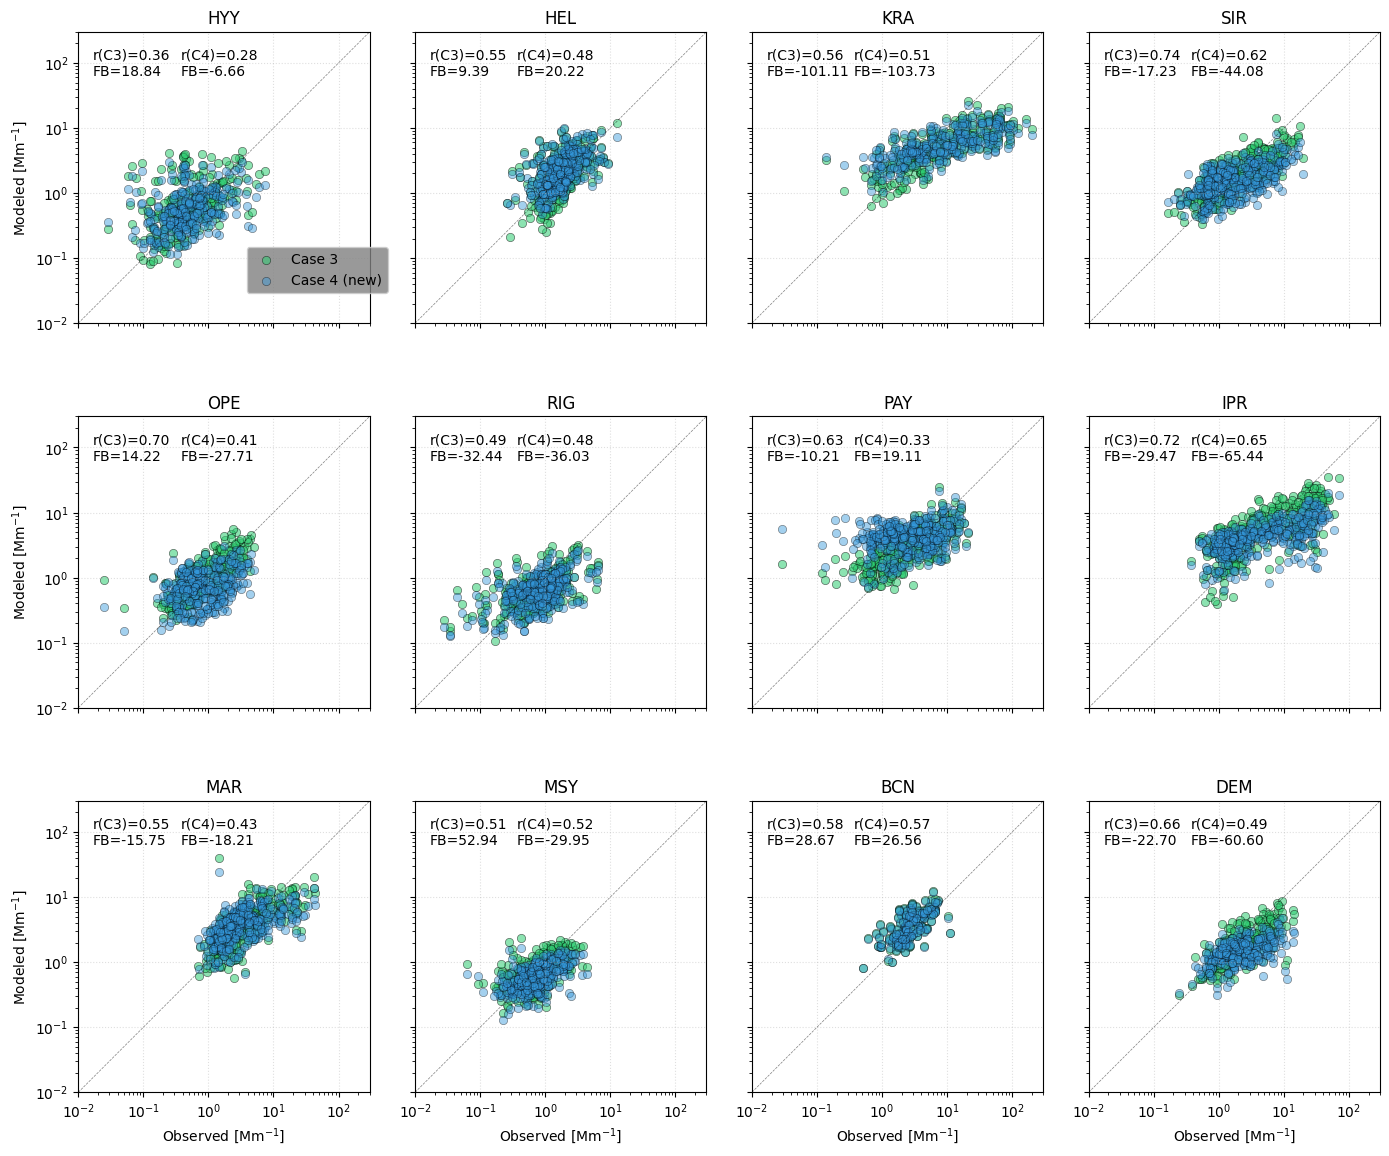

In [36]:
def plot_scatter_log_c(stations, mode='by_station', points='best'):
    #plot in one figure
    fig, axs = plt.subplots(3, 4, figsize=(14, 14), sharex=True, sharey=True)
    #reduce space between subplots
    fig.subplots_adjust(hspace=-0.45, wspace=0.12)
    #flatten the axs
    axs = axs.flatten()
    #ri_tables/monarch_best_strongly/RI_all/no_secondary/
    for i, stn in enumerate(stations):
        # Calcula los valores para cada caso y la observación
        #abs_mod_weakly = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
        #                                               SA=False, mode=mode, points=points, model='monarch_best', case='weakly')
        #abs_mod_moderately = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
        #                                                   SA=False, mode=mode, points=points, model='monarch_best', case='moderately')
        abs_mod_strongly = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                         SA=False, mode=mode, points=points, model='monarch_best', case='newcase')
        abs_oa = ut.calculate_absorption4oa_ns(dict_of_names['acr_first'][stn], best=True, points=points,\
                                                mass_mode='best', mode=mode, model='monarch_best_oa')
        abs_observed = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)


        #axs[i].scatter(abs_observed, abs_mod_weakly, color='#27AE60', label='Case 1', alpha=0.8, marker='s')
        #axs[i].scatter(abs_observed, abs_mod_moderately, color='#F1C40F', label='Case 2', alpha=0.9, marker='x', linewidth=1.5)
        axs[i].scatter(abs_observed, abs_mod_strongly, color='#2ECC71', label='Case 3', alpha=0.55, edgecolor='black', linewidth=0.5)
        axs[i].scatter(abs_observed, abs_oa, color='#3498DB', label='Case 4 (new)', alpha=0.45, edgecolor='black', linewidth=0.5)
        axs[i].minorticks_on()
        axs[i].set_xlim([0.01, 300])
        axs[i].set_ylim([0.01,300])

        #plot a diagonal line
        axs[i].plot([0.01, 300], [0.01, 300], linestyle='--', color='black', alpha=0.5, linewidth=0.5)
        #set title
        axs[i].set_title(stn)
        #set axis labels just in the bottom and left subplots
        if i in [8, 9, 10, 11]:
            axs[i].set_xlabel('Observed [Mm$^{-1}$]')
        if i in [0, 4, 8]:
            axs[i].set_ylabel('Modeled [Mm$^{-1}$]')
        #add annotation with correlation coefficient, and mean bias for each case/station using the function calculate_statistics
        #calculate statistics
        results = calculate_statistics_nosoa(stn, points, mode=mode)
        #add annotation
        axs[i].annotate(f"r(C3)={results['strongly']['r']:.2f}\nFB={results['strongly']['fb']:.2f}", 
                        xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
        axs[i].annotate(f"r(C4)={results['total']['r']:.2f}\nFB={results['total']['fb']:.2f}", 
                        xy=(0.35, 0.85), xycoords='axes fraction', fontsize=10)
        #axs[i].annotate(f"r(c3)={results['strongly']['r']:.2f}\nFB={results['strongly']['fb']:.2f}", 
        #                xy=(0.65, 0.85), xycoords='axes fraction', fontsize=10)

        #set log scale
        axs[i].set_xscale('log')
        axs[i].set_yscale('log')
        #set grid dotted
        axs[i].grid(True, linestyle=':', alpha=0.4)
        axs[i].set_aspect('equal', adjustable='box')
        #add legend in bottom of only first subplot
        axs[0].legend(loc='lower center', bbox_to_anchor=(0.82, 0.08), ncol=1, facecolor='gray')
    # Ajustar el layout para evitar la superposición
    plt.tight_layout()

    os.makedirs('figures_paper/scatter_opt/', exist_ok=True)
    #savefig 
    plt.savefig(f"figures_paper/scatter_opt/scatter_opt_cases_{points}_{mode}_newcase.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_scatter_log_c(station_names[::-1], mode='by_station', points='complete')

In [10]:
#get statistics for all stations
res = {}
for stn in station_names:
    res[stn] = calculate_statistics_nosoa(stn, points='complete', mode='by_station')

In [13]:
#show just strongly and total
tbl = {}
for stn in station_names[::-1]:
    tbl[stn] = {
        'r_strongly': res[stn]['strongly']['r'],
        'r_moderately': res[stn]['moderately']['r'],
        'r_weakly': res[stn]['weakly']['r'],
        'r_newcase': res[stn]['newcase']['r'],
        'fb_strongly': res[stn]['strongly']['fb'],
        'fb_moderately': res[stn]['moderately']['fb'],
        'fb_weakly': res[stn]['weakly']['fb'],
        'fb_newcase': res[stn]['newcase']['fb'],
        'fac2_strongly': res[stn]['strongly']['fac2'],
        'fac2_moderately': res[stn]['moderately']['fac2'],
        'fac2_weakly': res[stn]['weakly']['fac2'],
        'fac2_newcase': res[stn]['newcase']['fac2'],
        'r_total': res[stn]['total']['r'],
        'fb_total': res[stn]['total']['fb'],
        'fac2_total': res[stn]['total']['fac2']
    }

In [14]:
tbl 

{'HYY': {'r_strongly': 0.36,
  'r_moderately': 0.34,
  'r_weakly': 0.34,
  'r_newcase': 0.34,
  'fb_strongly': 18.84,
  'fb_moderately': 17.63,
  'fb_weakly': 16.06,
  'fb_newcase': 16.65,
  'fac2_strongly': 63.25,
  'fac2_moderately': 63.96,
  'fac2_weakly': 63.6,
  'fac2_newcase': 63.96,
  'r_total': 0.28,
  'fb_total': -6.66,
  'fac2_total': 58.66},
 'HEL': {'r_strongly': 0.55,
  'r_moderately': 0.54,
  'r_weakly': 0.55,
  'r_newcase': 0.54,
  'fb_strongly': 9.39,
  'fb_moderately': 10.11,
  'fb_weakly': 10.48,
  'fb_newcase': 11.56,
  'fac2_strongly': 73.42,
  'fac2_moderately': 73.15,
  'fac2_weakly': 73.42,
  'fac2_newcase': 74.79,
  'r_total': 0.48,
  'fb_total': 20.22,
  'fac2_total': 78.08},
 'KRA': {'r_strongly': 0.56,
  'r_moderately': 0.57,
  'r_weakly': 0.57,
  'r_newcase': 0.57,
  'fb_strongly': -101.11,
  'fb_moderately': -103.09,
  'fb_weakly': -103.14,
  'fb_newcase': -102.97,
  'fac2_strongly': 48.92,
  'fac2_moderately': 49.28,
  'fac2_weakly': 49.28,
  'fac2_newcase

## Absorption statistical table:

In [6]:
data_w = pd.read_csv(f'ri_tables/monarch_best_weakly/RI_all/no_secondary/RI_SLSQP_best.csv')
data_m = pd.read_csv(f'ri_tables/monarch_best_moderately/RI_all/no_secondary/RI_SLSQP_best.csv')
data_s = pd.read_csv(f'ri_tables/monarch_best_strongly/RI_all/no_secondary/RI_SLSQP_best.csv')
data_n = pd.read_csv(f'ri_tables/monarch_best_newcase/RI_all/no_secondary/RI_SLSQP_best.csv')
data_oa = pd.read_csv(f'ri_tables/monarch_best_oa/RI_all/RI_SLSQP_best.csv')

data_w.set_index('RI_name', inplace=True)
data_m.set_index('RI_name', inplace=True)
data_s.set_index('RI_name', inplace=True)
data_n.set_index('RI_name', inplace=True)
data_oa.set_index('RI_name', inplace=True)

data_w.columns = ['w']
data_m.columns = ['m']
data_s.columns = ['s']
data_n.columns = ['n']
data_oa.columns = ['oa']

df_all = pd.concat([data_w, data_m, data_s, data_n,data_oa], axis=1)

In [7]:
df_all 

,w,m,s,n,oa
RI_name,,,,,
gfas,0.0646,0.0656,0.1219,0.0571,NaN
resi,0.0411,0.0410,0.0397,0.0403,NaN
ship,0.0646,0.0656,0.1081,0.0571,NaN
traf,0.0011,0.0011,0.0011,0.0049,NaN
othr,0.0011,0.0011,0.0011,0.0011,NaN
oa,NaN,NaN,NaN,NaN,0.0187


In [16]:
def calculate_statistics_4brc(stn, ri_brc_strng, ri_brc_blchd, factor):
    model = dr.get_explct4brcmass(dict_of_names['acr_first'][stn], remove_negatives=True)
    model_abs = ca.get_absorption4brc(model, WAVELENGTH=constants.WAVELENGTH,\
                                        REL_HUM=constants.RELATIVE_HUMIDITY,\
                                        ri_brc_strng=ri_brc_strng, ri_brc_blchd=ri_brc_blchd, SA=False)*factor
    obs = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)
    #hacer collocation de los datos para cada caso 
    obs, model_abs = st.preproc_data_collocation(obs, model_abs, filled=False)
    # Calcular las métricas
    corr = st.calculate_corr(obs, model_abs)
    fb = st.calculate_fb(obs, model_abs)
    fac2 = st.calculate_fac2(obs, model_abs)

    # Crear un diccionario para almacenar los resultados para cada caso
    resultados = {
        'r': corr,
        'fb': fb,
        'fac2': fac2
    }
    return resultados

In [17]:
results_brc = {}
for stn in station_names[::-1]:
    results_brc[stn] = calculate_statistics_4brc(stn, df_all.loc['gfas']['s'], df_all.loc['gfas']['w'], factor=7)


In [18]:
df_all

,w,m,s,n,oa
RI_name,,,,,
gfas,0.0646,0.0656,0.1219,0.0571,NaN
resi,0.0411,0.0410,0.0397,0.0403,NaN
ship,0.0646,0.0656,0.1081,0.0571,NaN
traf,0.0011,0.0011,0.0011,0.0049,NaN
othr,0.0011,0.0011,0.0011,0.0011,NaN
oa,NaN,NaN,NaN,NaN,0.0187


In [20]:
df_all.loc['gfas']['w']

0.0646

In [21]:
df_all.loc['gfas']['m']

0.0656

In [19]:
results_brc = {}
for stn in station_names[::-1]:
    results_brc[stn] = calculate_statistics_4brc(stn, df_all.loc['gfas']['m'], df_all.loc['gfas']['w'], factor=7)

In [20]:
results_brc 

{'HYY': {'r': 0.31, 'fb': 15.55, 'fac2': 58.3},
 'HEL': {'r': 0.54, 'fb': -25.17, 'fac2': 55.34},
 'KRA': {'r': 0.53, 'fb': -87.95, 'fac2': 51.44},
 'SIR': {'r': 0.69, 'fb': -1.02, 'fac2': 59.23},
 'OPE': {'r': 0.67, 'fb': 16.05, 'fac2': 76.38},
 'RIG': {'r': 0.51, 'fb': 8.61, 'fac2': 70.95},
 'PAY': {'r': 0.6, 'fb': -95.85, 'fac2': 44.66},
 'IPR': {'r': 0.64, 'fb': -80.1, 'fac2': 51.1},
 'MAR': {'r': 0.19, 'fb': -71.81, 'fac2': 45.04},
 'MSY': {'r': 0.52, 'fb': 83.09, 'fac2': 34.76},
 'BCN': {'r': 0.51, 'fb': 8.91, 'fac2': 79.41},
 'DEM': {'r': 0.41, 'fb': -51.75, 'fac2': 66.08}}

In [21]:
results_brc 

{'HYY': {'r': 0.31, 'fb': 15.55, 'fac2': 58.3},
 'HEL': {'r': 0.54, 'fb': -25.17, 'fac2': 55.34},
 'KRA': {'r': 0.53, 'fb': -87.95, 'fac2': 51.44},
 'SIR': {'r': 0.69, 'fb': -1.02, 'fac2': 59.23},
 'OPE': {'r': 0.67, 'fb': 16.05, 'fac2': 76.38},
 'RIG': {'r': 0.51, 'fb': 8.61, 'fac2': 70.95},
 'PAY': {'r': 0.6, 'fb': -95.85, 'fac2': 44.66},
 'IPR': {'r': 0.64, 'fb': -80.1, 'fac2': 51.1},
 'MAR': {'r': 0.19, 'fb': -71.81, 'fac2': 45.04},
 'MSY': {'r': 0.52, 'fb': 83.09, 'fac2': 34.76},
 'BCN': {'r': 0.51, 'fb': 8.91, 'fac2': 79.41},
 'DEM': {'r': 0.41, 'fb': -51.75, 'fac2': 66.08}}

In [22]:
# to tbl dict add results_brc in each station r_brc, fb_brc, fac2_brc
for stn in station_names[::-1]:
    tbl[stn]['r_brc'] = results_brc[stn]['r']
    tbl[stn]['fb_brc'] = results_brc[stn]['fb']
    tbl[stn]['fac2_brc'] = results_brc[stn]['fac2']

In [23]:
tbl

{'HYY': {'r_strongly': 0.36,
  'r_moderately': 0.34,
  'r_weakly': 0.34,
  'r_newcase': 0.34,
  'fb_strongly': 18.84,
  'fb_moderately': 17.63,
  'fb_weakly': 16.06,
  'fb_newcase': 16.65,
  'fac2_strongly': 63.25,
  'fac2_moderately': 63.96,
  'fac2_weakly': 63.6,
  'fac2_newcase': 63.96,
  'r_total': 0.28,
  'fb_total': -6.66,
  'fac2_total': 58.66,
  'r_brc': 0.31,
  'fb_brc': 15.55,
  'fac2_brc': 58.3},
 'HEL': {'r_strongly': 0.55,
  'r_moderately': 0.54,
  'r_weakly': 0.55,
  'r_newcase': 0.54,
  'fb_strongly': 9.39,
  'fb_moderately': 10.11,
  'fb_weakly': 10.48,
  'fb_newcase': 11.56,
  'fac2_strongly': 73.42,
  'fac2_moderately': 73.15,
  'fac2_weakly': 73.42,
  'fac2_newcase': 74.79,
  'r_total': 0.48,
  'fb_total': 20.22,
  'fac2_total': 78.08,
  'r_brc': 0.54,
  'fb_brc': -25.17,
  'fac2_brc': 55.34},
 'KRA': {'r_strongly': 0.56,
  'r_moderately': 0.57,
  'r_weakly': 0.57,
  'r_newcase': 0.57,
  'fb_strongly': -101.11,
  'fb_moderately': -103.09,
  'fb_weakly': -103.14,
  'f

In [24]:
#make tbl a dataframe 
df_tbl = pd.DataFrame(tbl).T

In [25]:
df_tbl 

,r_strongly,r_moderately,r_weakly,r_newcase,fb_strongly,fb_moderately,fb_weakly,fb_newcase,fac2_strongly,fac2_moderately,fac2_weakly,fac2_newcase,r_total,fb_total,fac2_total,r_brc,fb_brc,fac2_brc
HYY,0.36,0.34,0.34,0.34,18.84,17.63,16.06,16.65,63.25,63.96,63.60,63.96,0.28,-6.66,58.66,0.31,15.55,58.30
HEL,0.55,0.54,0.55,0.54,9.39,10.11,10.48,11.56,73.42,73.15,73.42,74.79,0.48,20.22,78.08,0.54,-25.17,55.34
KRA,0.56,0.57,0.57,0.57,-101.11,-103.09,-103.14,-102.97,48.92,49.28,49.28,48.92,0.51,-103.73,43.17,0.53,-87.95,51.44
SIR,0.74,0.74,0.74,0.74,-17.23,-19.00,-18.44,-17.59,70.80,71.63,71.90,71.07,0.62,-44.08,56.75,0.69,-1.02,59.23
OPE,0.70,0.73,0.73,0.72,14.22,10.19,9.85,11.80,80.58,82.85,83.17,80.58,0.41,-27.71,56.31,0.67,16.05,76.38
RIG,0.49,0.48,0.48,0.48,-32.44,-33.18,-35.39,-35.53,65.08,65.36,67.04,67.04,0.48,-36.03,67.32,0.51,8.61,70.95
PAY,0.63,0.63,0.63,0.63,-10.21,-10.23,-10.27,-9.77,68.77,69.04,69.04,68.77,0.33,19.11,44.11,0.60,-95.85,44.66
IPR,0.72,0.72,0.72,0.72,-29.47,-28.06,-28.11,-28.29,53.85,54.40,54.40,54.40,0.65,-65.44,43.13,0.64,-80.10,51.10
MAR,0.55,0.55,0.55,0.55,-15.75,-15.75,-16.10,-15.10,79.04,79.04,79.04,79.32,0.43,-18.21,65.16,0.19,-71.81,45.04
MSY,0.51,0.49,0.53,0.54,52.94,49.85,-11.22,-11.64,53.56,55.84,77.78,78.63,0.52,-29.95,80.34,0.52,83.09,34.76


In [31]:
# Crear un nuevo DataFrame con la estructura correcta manualmente, 

data_multiindex = {
    ('Case 1', 'r'): df_tbl['r_weakly'],
    ('Case 1', 'FB'): df_tbl['fb_weakly'],
    ('Case 1', 'FAC2'): df_tbl['fac2_weakly'],
    ('Case 2', 'r'): df_tbl['r_moderately'],
    ('Case 2', 'FB'): df_tbl['fb_moderately'],
    ('Case 2', 'FAC2'): df_tbl['fac2_moderately'],
    ('Case 3', 'r'): df_tbl['r_strongly'],
    ('Case 3', 'FB'): df_tbl['fb_strongly'],
    ('Case 3', 'FAC2'): df_tbl['fac2_strongly'],
    ('Case 4', 'r'): df_tbl['r_newcase'],
    ('Case 4', 'FB'): df_tbl['fb_newcase'],
    ('Case 4', 'FAC2'): df_tbl['fac2_newcase'],
    ('Case 5', 'r'): df_tbl['r_total'],
    ('Case 5', 'FB'): df_tbl['fb_total'],
    ('Case 5', 'FAC2'): df_tbl['fac2_total'],
    ('Case 6', 'r'): df_tbl['r_brc'],
    ('Case 6', 'FB'): df_tbl['fb_brc'],
    ('Case 6', 'FAC2'): df_tbl['fac2_brc']
}

In [32]:
index = pd.Index(['HYY', 'HEL', 'KRA', 'SIR', 'OPE', 'RIG', 'PAY', 'IPR', 'MAR', 'MSY', 'BCN', 'DEM'], name='Station')
columns = pd.MultiIndex.from_tuples([('Case 1', 'r'), ('Case 1', 'FB'), ('Case 1', 'FAC2'),\
                                     ('Case 2', 'r'), ('Case 2', 'FB'), ('Case 2', 'FAC2'),\
                                     ('Case 3', 'r'), ('Case 3', 'FB'), ('Case 3', 'FAC2'),\
                                     ('Case 4', 'r'), ('Case 4', 'FB'), ('Case 4', 'FAC2'),\
                                     ('Case 5', 'r'), ('Case 5', 'FB'), ('Case 5', 'FAC2'),\
                                     ('Case 6', 'r'), ('Case 6', 'FB'), ('Case 6', 'FAC2')], names=['Cases', 'Metric'])

# Convertir los datos en un formato adecuado para el DataFrame
data_for_df = {}
for (case, measure), values in data_multiindex.items():
    for station, value in values.items():
        data_for_df[(case, measure, station)] = value

# Reorganizar los datos para la creación del DataFrame
reorganized_data = {station: {('Case 1', 'r'): data_for_df.get(('Case 1', 'r', station)),
                              ('Case 1', 'FB'): data_for_df.get(('Case 1', 'FB', station)),
                              ('Case 1', 'FAC2'): data_for_df.get(('Case 1','FAC2', station)),
                              ('Case 2', 'r'): data_for_df.get(('Case 2', 'r', station)),
                              ('Case 2', 'FB'): data_for_df.get(('Case 2', 'FB', station)),
                              ('Case 2', 'FAC2'): data_for_df.get(('Case 2','FAC2', station)),
                              ('Case 3', 'r'): data_for_df.get(('Case 3', 'r', station)),
                              ('Case 3', 'FB'): data_for_df.get(('Case 3', 'FB', station)),
                              ('Case 3', 'FAC2'): data_for_df.get(('Case 3','FAC2', station)),
                              ('Case 4', 'r'): data_for_df.get(('Case 4', 'r', station)),
                              ('Case 4', 'FB'): data_for_df.get(('Case 4', 'FB', station)),
                              ('Case 4', 'FAC2'): data_for_df.get(('Case 4','FAC2', station)),
                              ('Case 5', 'r'): data_for_df.get(('Case 5', 'r', station)),
                              ('Case 5', 'FB'): data_for_df.get(('Case 5', 'FB', station)),
                              ('Case 5', 'FAC2'): data_for_df.get(('Case 5','FAC2', station)),
                              ('Case 6', 'r'): data_for_df.get(('Case 6', 'r', station)),
                              ('Case 6', 'FB'): data_for_df.get(('Case 6', 'FB', station)),
                              ('Case 6', 'FAC2'): data_for_df.get(('Case 6','FAC2', station)),} for station in index}


# Crear el DataFrame MultiIndex
df_multiindex_corrected = pd.DataFrame(reorganized_data).T
df_multiindex_corrected.columns = columns

df_multiindex_corrected

Cases  Case 1                Case 2                Case 3                 \
Metric      r      FB   FAC2      r      FB   FAC2      r      FB   FAC2   
HYY      0.34   16.06  63.60   0.34   17.63  63.96   0.36   18.84  63.25   
HEL      0.55   10.48  73.42   0.54   10.11  73.15   0.55    9.39  73.42   
KRA      0.57 -103.14  49.28   0.57 -103.09  49.28   0.56 -101.11  48.92   
SIR      0.74  -18.44  71.90   0.74  -19.00  71.63   0.74  -17.23  70.80   
OPE      0.73    9.85  83.17   0.73   10.19  82.85   0.70   14.22  80.58   
RIG      0.48  -35.39  67.04   0.48  -33.18  65.36   0.49  -32.44  65.08   
PAY      0.63  -10.27  69.04   0.63  -10.23  69.04   0.63  -10.21  68.77   
IPR      0.72  -28.11  54.40   0.72  -28.06  54.40   0.72  -29.47  53.85   
MAR      0.55  -16.10  79.04   0.55  -15.75  79.04   0.55  -15.75  79.04   
MSY      0.53  -11.22  77.78   0.49   49.85  55.84   0.51   52.94  53.56   
BCN      0.57   28.66  78.68   0.57   28.71  78.68   0.58   28.67  78.68   
DEM      0.70  -24.29  84.81   0.70  -24.01  84.45   0.66  -22.70  84.10   

Cases  Case 4                Case 5                Case 6                
Metric      r      FB   FAC2      r      FB   FAC2      r     FB   FAC2  
HYY      0.34   16.65  63.96   0.28   -6.66  58.66   0.31  15.55  58.30  
HEL      0.54   11.56  74.79   0.48   20.22  78.08   0.54 -25.17  55.34  
KRA      0.57 -102.97  48.92   0.51 -103.73  43.17   0.53 -87.95  51.44  
SIR      0.74  -17.59  71.07   0.62  -44.08  56.75   0.69  -1.02  59.23  
OPE      0.72   11.80  80.58   0.41  -27.71  56.31   0.67  16.05  76.38  
RIG      0.48  -35.53  67.04   0.48  -36.03  67.32   0.51   8.61  70.95  
PAY      0.63   -9.77  68.77   0.33   19.11  44.11   0.60 -95.85  44.66  
IPR      0.72  -28.29  54.40   0.65  -65.44  43.13   0.64 -80.10  51.10  
MAR      0.55  -15.10  79.32   0.43  -18.21  65.16   0.19 -71.81  45.04  
MSY      0.54  -11.64  78.63   0.52  -29.95  80.34   0.52  83.09  34.76  
BCN      0.57   29.28  77.94   0.57   26.56  80.88   0.51   8.91  79.41  
DEM      0.70  -24.71  84.45   0.49  -60.60  62.54   0.41 -51.75  66.08

In [33]:
df_final = df_multiindex_corrected.style.format(subset=['Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5', 'Case 6'], precision=2)

In [34]:
latex_df = df_final.to_latex(
    caption="Selected statistics",
    clines="skip-last;data",
    convert_css=True,
    position_float="centering",
    multicol_align="|c|",
    hrules=True,
)
print(latex_df)


\begin{table}
\centering
\caption{Selected statistics}
\begin{tabular}{lrrrrrrrrrrrrrrrrrr}
\toprule
Cases & \multicolumn{3}{|c|}{Case 1} & \multicolumn{3}{|c|}{Case 2} & \multicolumn{3}{|c|}{Case 3} & \multicolumn{3}{|c|}{Case 4} & \multicolumn{3}{|c|}{Case 5} & \multicolumn{3}{|c|}{Case 6} \\
Metric & r & FB & FAC2 & r & FB & FAC2 & r & FB & FAC2 & r & FB & FAC2 & r & FB & FAC2 & r & FB & FAC2 \\
\midrule
HYY & 0.34 & 16.06 & 63.60 & 0.34 & 17.63 & 63.96 & 0.36 & 18.84 & 63.25 & 0.34 & 16.65 & 63.96 & 0.28 & -6.66 & 58.66 & 0.31 & 15.55 & 58.30 \\
HEL & 0.55 & 10.48 & 73.42 & 0.54 & 10.11 & 73.15 & 0.55 & 9.39 & 73.42 & 0.54 & 11.56 & 74.79 & 0.48 & 20.22 & 78.08 & 0.54 & -25.17 & 55.34 \\
KRA & 0.57 & -103.14 & 49.28 & 0.57 & -103.09 & 49.28 & 0.56 & -101.11 & 48.92 & 0.57 & -102.97 & 48.92 & 0.51 & -103.73 & 43.17 & 0.53 & -87.95 & 51.44 \\
SIR & 0.74 & -18.44 & 71.90 & 0.74 & -19.00 & 71.63 & 0.74 & -17.23 & 70.80 & 0.74 & -17.59 & 71.07 & 0.62 & -44.08 & 56.75 & 0.69 & -1.02 & 59

In [33]:
df_multiindex_corrected

Cases  Case 1                Case 2                Case 3                 \
Metric      r      FB   FAC2      r      FB   FAC2      r      FB   FAC2   
HYY      0.34   16.06  63.60   0.34   17.63  63.96   0.36   18.84  63.25   
HEL      0.55   10.48  73.42   0.54   10.11  73.15   0.55    9.39  73.42   
KRA      0.57 -103.14  49.28   0.57 -103.09  49.28   0.56 -101.11  48.92   
SIR      0.74  -18.44  71.90   0.74  -19.00  71.63   0.74  -17.23  70.80   
OPE      0.73    9.85  83.17   0.73   10.19  82.85   0.70   14.22  80.58   
RIG      0.48  -35.39  67.04   0.48  -33.18  65.36   0.49  -32.44  65.08   
PAY      0.63  -10.27  69.04   0.63  -10.23  69.04   0.63  -10.21  68.77   
IPR      0.72  -28.11  54.40   0.72  -28.06  54.40   0.72  -29.47  53.85   
MAR      0.55  -16.10  79.04   0.55  -15.75  79.04   0.55  -15.75  79.04   
MSY      0.53  -11.22  77.78   0.49   49.85  55.84   0.51   52.94  53.56   
BCN      0.57   28.66  78.68   0.57   28.71  78.68   0.58   28.67  78.68   
DEM      0.70  -24.29  84.81   0.70  -24.01  84.45   0.66  -22.70  84.10   

Cases  Case 4                Case 5                
Metric      r      FB   FAC2      r     FB   FAC2  
HYY      0.28   -6.66  58.66   0.31  15.55  58.30  
HEL      0.48   20.22  78.08   0.54 -25.17  55.34  
KRA      0.51 -103.73  43.17   0.53 -87.95  51.44  
SIR      0.62  -44.08  56.75   0.69  -1.02  59.23  
OPE      0.41  -27.71  56.31   0.67  16.05  76.38  
RIG      0.48  -36.03  67.32   0.51   8.61  70.95  
PAY      0.33   19.11  44.11   0.60 -95.85  44.66  
IPR      0.65  -65.44  43.13   0.64 -80.10  51.10  
MAR      0.43  -18.21  65.16   0.19 -71.81  45.04  
MSY      0.52  -29.95  80.34   0.52  83.09  34.76  
BCN      0.57   26.56  80.88   0.51   8.91  79.41  
DEM      0.49  -60.60  62.54   0.41 -51.75  66.08

In [34]:
import numpy as np
#calculating boundaries
def k_lambda(k, w, wavelength):
    """Calculates absorption of light at specific wavelength based on Saleh methodology."""
    return np.round(k * ((550/wavelength)**w), 4)

very weakly

In [35]:
inf_w_limit = k_lambda(1e-4, 6, 370)
sup_w_limit = k_lambda(1e-3, 9, 370)

print(f'inferior limit: {inf_w_limit}, superior limit: {sup_w_limit}')

inferior limit: 0.0011, superior limit: 0.0354


0.0354

weakly

In [ ]:
inf_limit = k_lambda(1e-3, 4, 370)
sup_limit = k_lambda(1e-2, 7, 370)

print(f'inferior limit: {inf_limit}, superior limit: {sup_limit}')

inferior limit: 0.0537, superior limit: 0.1604


moderately

In [ ]:
inf_m_limit = k_lambda(1e-2, 1.5, 370)
sup_m_limit = k_lambda(1e-1, 4, 370)

print(f'inferior limit: {inf_m_limit}, superior limit: {sup_m_limit}')

inferior limit: 0.0181, superior limit: 0.4883


strongly

In [ ]:
inf_s_limit = k_lambda(1e-1, 0.5, 370)
sup_s_limit = k_lambda(0.3, 1.5, 370)

print(f'inferior limit: {inf_s_limit}, superior limit: {sup_s_limit}')

inferior limit: 0.1219, superior limit: 0.5437
